# SECTION-1

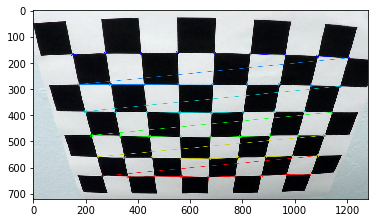

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Given number of corners in each direction
nx = 9 
ny = 6  

# Loading a test image to check the calibration
frame_name = '../camera_cal/calibration2.jpg'
img = cv2.imread(frame_name)

# Convert to grayscale for the test
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

# Display the corners on the image 
if ret == True: 
    cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
    plt.imshow(img)


# Section-2

In [2]:
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] 
imgpoints = [] 

# Getting all images together through the os feature.
images = glob.glob('../camera_cal/calibration*.jpg')

# Going through the list
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points to the list for 
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(700)

        cv2.destroyAllWindows()

True

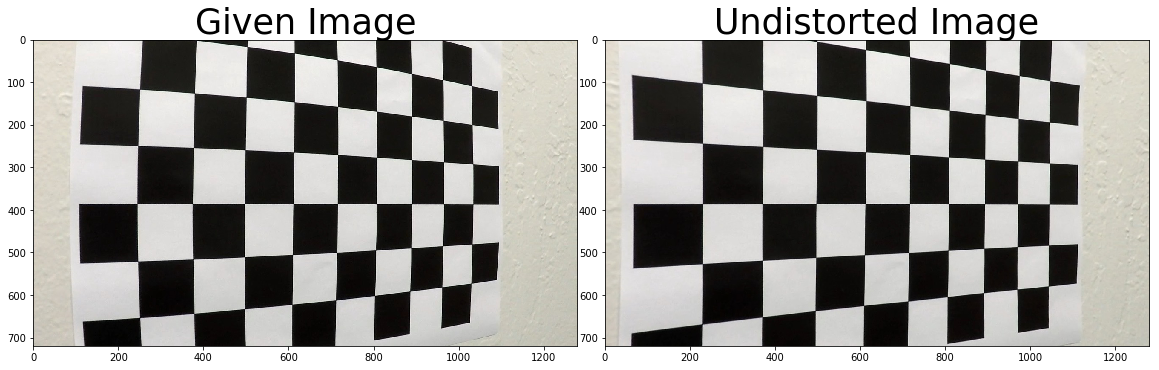

In [3]:
#Sample image to showcase the process
img = cv2.imread('../camera_cal/calibration5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

# Camera Calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Given Image', fontsize=35)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=35)
cv2.imwrite('Undistorted.jpg',dst)

# Section-3

True

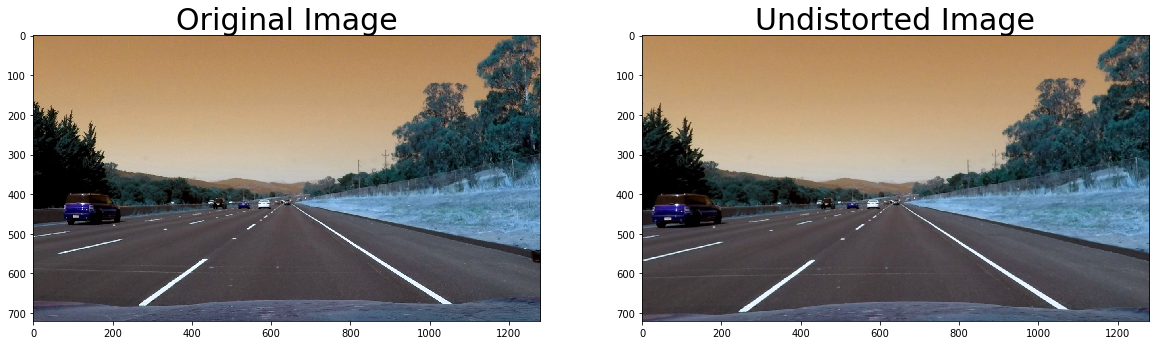

In [4]:
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

img = cv2.imread('../test_images/straight_lines2.jpg')
undist2 = undistort(img)
f, (ax1,ax2) = plt.subplots(1,2, figsize = (20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist2)
ax2.set_title('Undistorted Image', fontsize=30)
cv2.imwrite('UndistortedRoad.jpg',dst)

# Section-4

In [5]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get the tranformation and reverse matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to the required perspective
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

1280


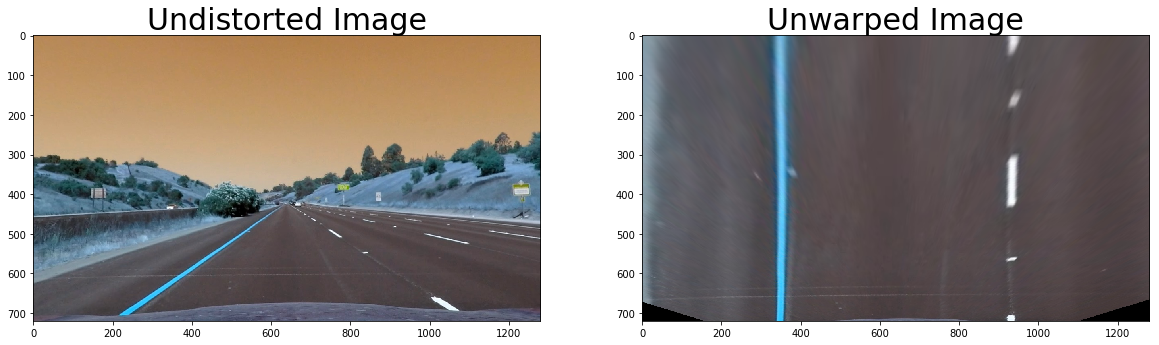

In [6]:
img = cv2.imread('../test_images/straight_lines1.jpg')
img_undistort = undistort(img)
h,w = img_undistort.shape[:2]

# define source and destination points for transform
offset = 350
src = np.float32([(575,465),
                  (707,465), 
                  (260,685), 
                  (1050,685)])
dst = np.float32([(offset,0),
                  (w-offset,0),
                  (offset,h),
                  (w-offset,h)])

img_unwarp, M, Minv = unwarp(img_undistort, src, dst)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_undistort)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(img_unwarp)
ax2.set_title('Unwarped Image', fontsize=30)
print(w)

# Section-5

# Section-5-1

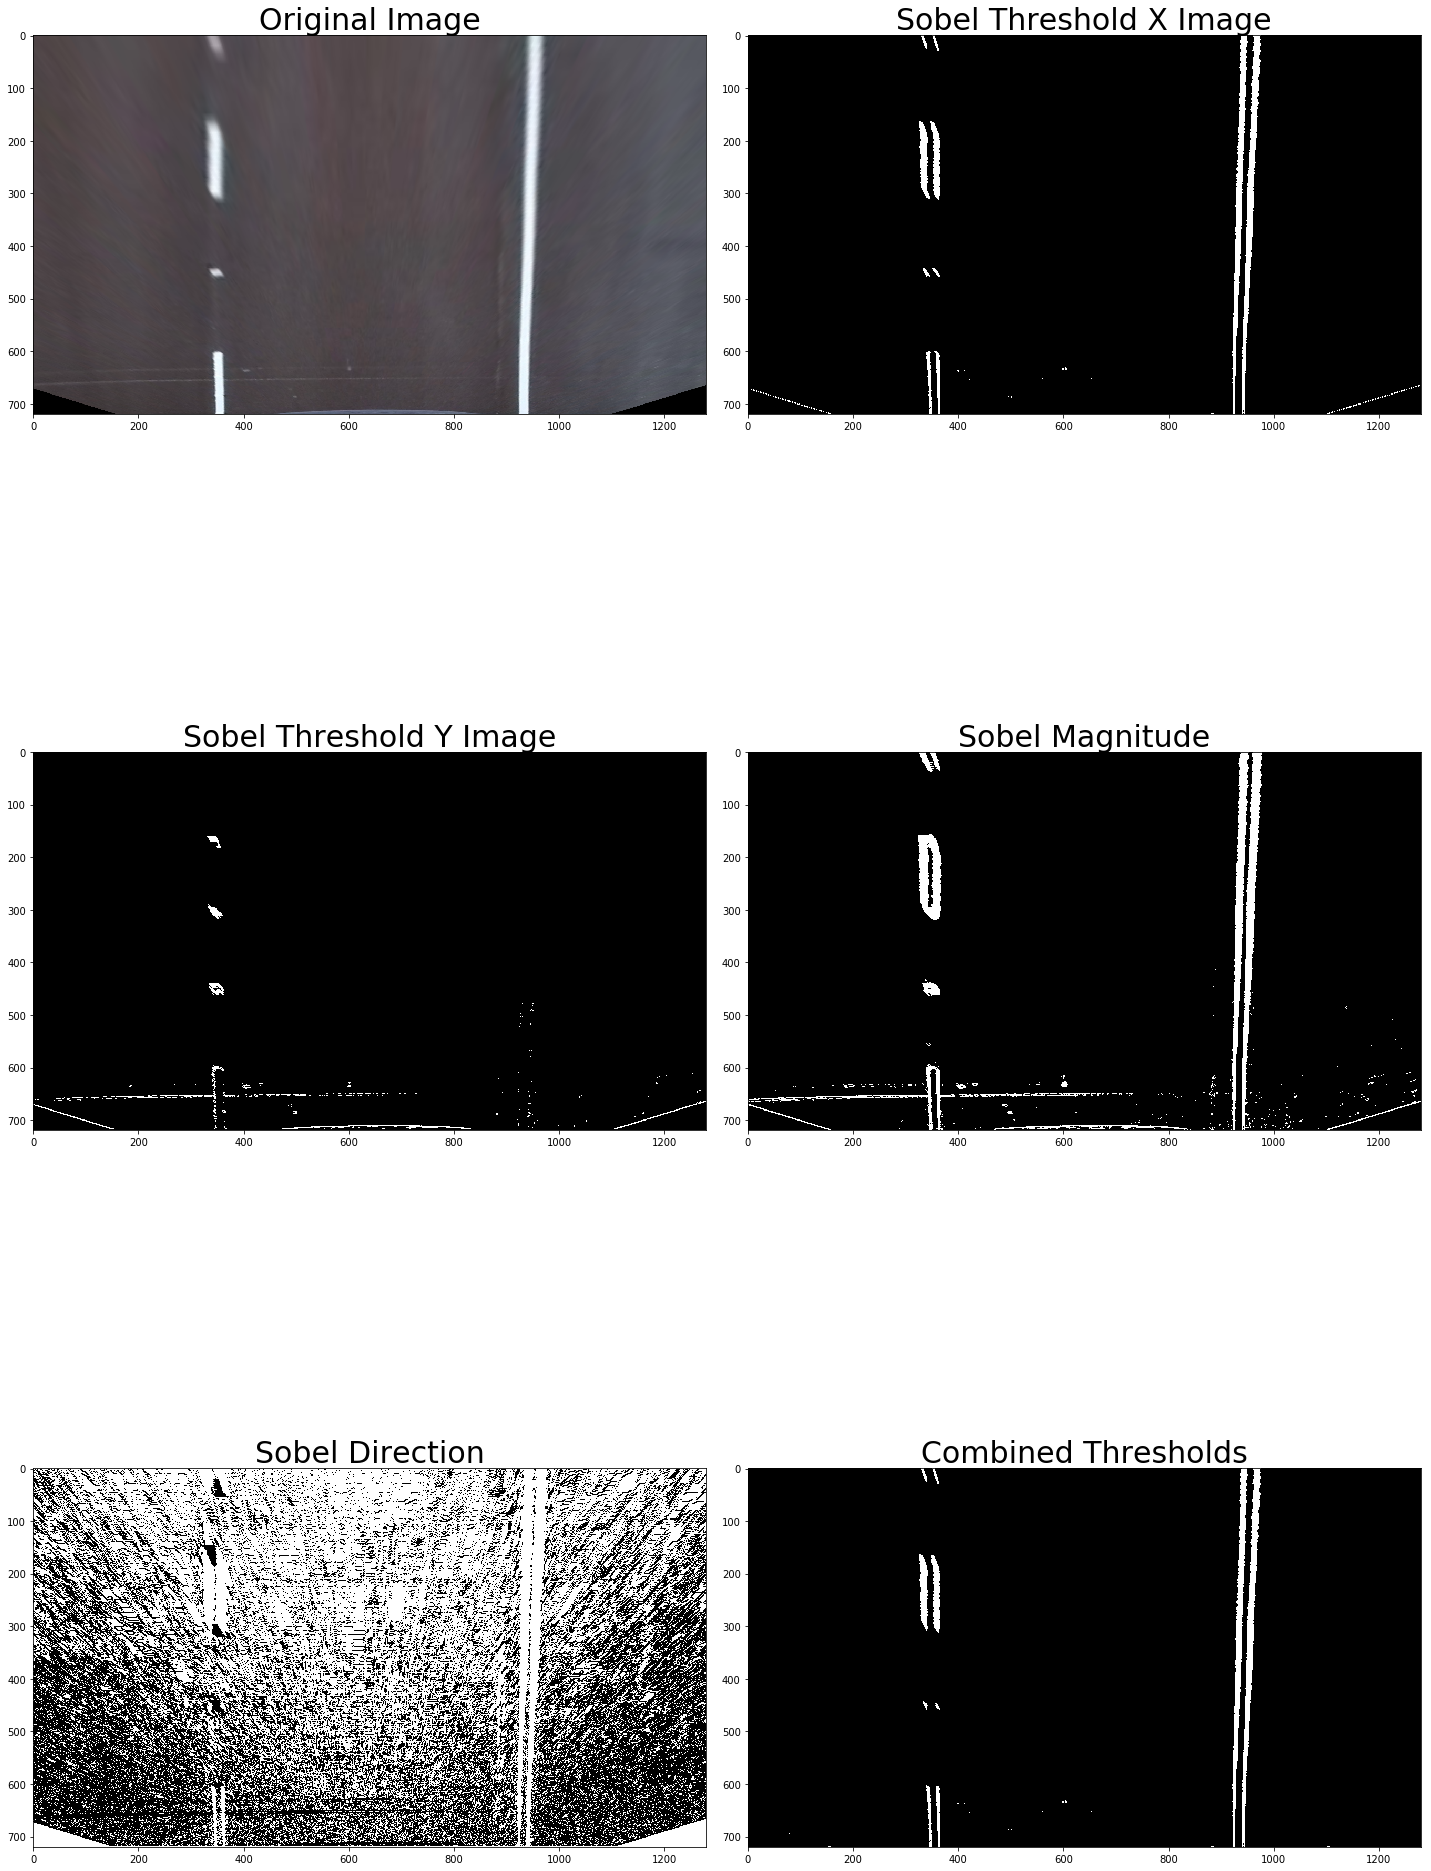

In [7]:
%matplotlib inline
img = cv2.imread('../test_images/straight_lines2.jpg')
undist2 = undistort(img)

unwarped, M, Minv = unwarp(undist2, src, dst)

def abs_sobel_thre(img, orient = 'x', sobel_kernel = 3, thre = (0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient == 'x', orient == 'y', ksize = sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scale_model = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(sobel)
    sbinary[(scale_model >= thre[0]) & (scale_model <= thre[1])] = 1
    binary_out = np.copy(sbinary)
    
    return binary_out
    
def mag_thre(img, sobel_kernel = 3, mag_thre = (0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs = np.power(sobelx,2) + np.power(sobely,2)
    abs_sobel = np.absolute(np.power(abs,0.5))
    
    scale_model = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(sobelx)
    sbinary[(scale_model >= mag_thre[0]) & (scale_model <= mag_thre[1])] = 1
    binary_out = np.copy(sbinary)
    
    return binary_out
    
def dir_thre(img, sobel_kernel = 3, thre = (0, np.pi/2)): 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobel_grad = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    #scale_model = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(sobelx)
    sbinary[(abs_sobel_grad >= thre[0]) & (abs_sobel_grad <= thre[1])] = 1
    binary_out = np.copy(sbinary)
    
    return binary_out

ksize = 3

gradx = abs_sobel_thre(unwarped, orient='x', sobel_kernel=ksize, thre=(25, 225))
grady = abs_sobel_thre(unwarped, orient='y', sobel_kernel=ksize, thre=(25, 225))
mag_binary = mag_thre(unwarped, sobel_kernel=ksize, mag_thre=(14, 230))
dir_binary = dir_thre(unwarped, sobel_kernel=ksize, thre=(0, 0.7))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (mag_binary == 1) & (dir_binary == 1))] = 1
#combined[((gradx == 1) & (dir_binary == 1))] = 1

f, ([ax1, ax2],[ax3,ax4], [ax5, ax6]) = plt.subplots(3, 2, figsize=(20, 30))
f.tight_layout()
ax1.imshow(unwarped)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(gradx, cmap = 'gray')
ax2.set_title('Sobel Threshold X Image', fontsize=30)
ax3.imshow(grady, cmap = 'gray')
ax3.set_title('Sobel Threshold Y Image', fontsize=30)
ax4.imshow(mag_binary, cmap = 'gray')
ax4.set_title('Sobel Magnitude', fontsize=30)
ax5.imshow(dir_binary, cmap = 'gray')
ax5.set_title('Sobel Direction', fontsize=30)
ax6.imshow(combined, cmap='gray')
ax6.set_title('Combined Thresholds', fontsize=30)

# Section-5-2

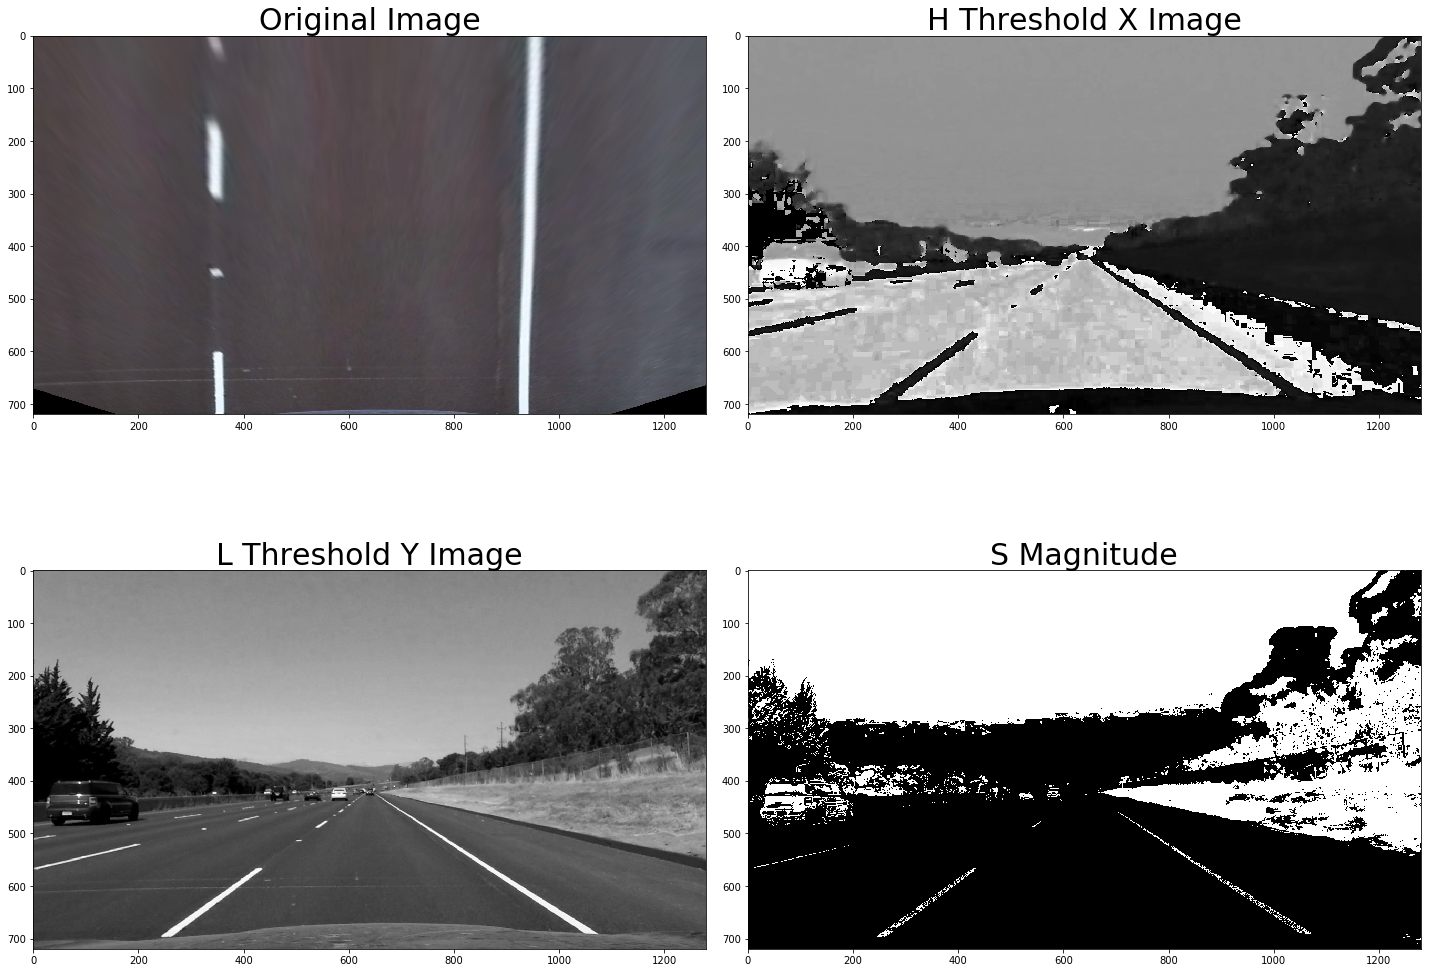

In [8]:
undist2 = undistort(img)

unwarped, M, Minv = unwarp(undist2, src, dst)

hls = cv2.cvtColor(undist2, cv2.COLOR_BGR2HLS)
h = hls[:,:,0]
s = hls[:,:,2]
l = hls[:,:,1]

like = np.zeros_like(s)
like[(s >= 80) & (s <= 230)] = 1

f, ([ax1, ax2],[ax3,ax4]) = plt.subplots(2, 2, figsize=(20, 15))
f.tight_layout()
ax1.imshow(unwarped)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(h, cmap = 'gray')
ax2.set_title('H Threshold X Image', fontsize=30)
ax3.imshow(l, cmap = 'gray')
ax3.set_title('L Threshold Y Image', fontsize=30)
ax4.imshow(like, cmap = 'gray')
ax4.set_title('S Magnitude', fontsize=30)

#unwarped, M = unwrap(like, src, dst, mtx, dist)
#plt.imshow(unwarped)

# Section-6

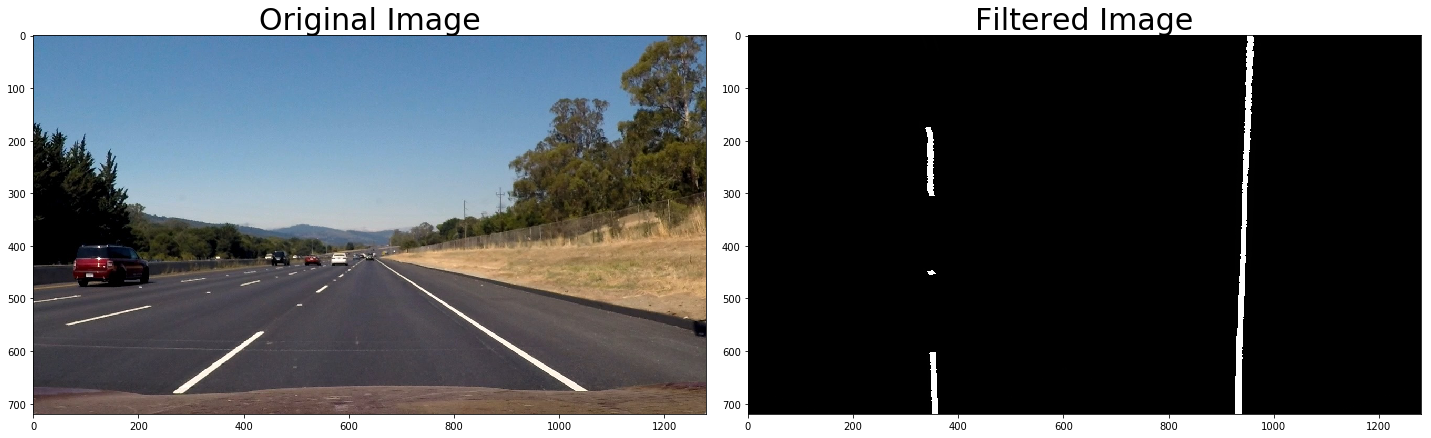

In [9]:
img = mpimg.imread('../test_images/straight_lines2.jpg')
def pipeline(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    undist2 = undistort(img)
    unwarped, M, Minv = unwarp(undist2, src, dst)
   
    # This is the HLS filter 
    hls = cv2.cvtColor(unwarped, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    # HSV Filter as adopted 
    hsv = cv2.cvtColor(unwarped, cv2.COLOR_BGR2HSV)

    low_threshold = np.array([15, 38, 125], dtype=np.uint8)
    high_threshold = np.array([35, 206, 255], dtype=np.uint8)  
    yellow_mask = cv2.inRange(hls, low_threshold, high_threshold)

    # Threshold for white color applied on the hsl color space 
    low_threshold = np.array([0, 200, 0], dtype=np.uint8)
    high_threshold = np.array([180, 255, 255], dtype=np.uint8)  
    white_mask = cv2.inRange(hls, low_threshold, high_threshold)

    # creating an image that combines the two images having the white and/or yellow lines seperately
    # note that here we use cv2.bitwise_or to ensure color pixels are considered from both the images 
    comb_hsv_img = cv2.bitwise_or(yellow_mask,white_mask)
    comb_hsv_img2 = cv2.bitwise_and(unwarped,unwarped,mask = comb_hsv_img)
    
    comb_img = np.zeros_like(comb_hsv_img2[:,:,0])
    #comb_img = np.zeros_like(comb_hsv_img2)
    
    comb_img[(comb_hsv_img2[:,:,0] > 60) | (comb_hsv_img2[:,:,1] > 60) | (comb_hsv_img2[:,:,2] > 60)] = 1 
 
    comb_img *= 255
    gradx = abs_sobel_thre(unwarped, orient='x', sobel_kernel=ksize, thre=(25, 245))
    grady = abs_sobel_thre(unwarped, orient='y', sobel_kernel=ksize, thre=(25, 245))
    mag_binary = mag_thre(unwarped, sobel_kernel=ksize, mag_thre=(14, 240))
    dir_binary = dir_thre(unwarped, sobel_kernel=ksize, thre=(0, 0.9))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (mag_binary == 1) & (dir_binary == 1))] = 1
    comb_img[(comb_img == 1)|(combined==1)] = 1
    
    return comb_img, Minv

filtered, M = pipeline(img)
    
f, ([ax1, ax2]) = plt.subplots(1, 2, figsize=(20, 20))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(filtered, cmap = 'gray')
ax2.set_title('Filtered Image', fontsize=30)

# Section-7

In [10]:
def sliding_window(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    
    # Since the perspective transform is already focusing on the lane lines in front of the vehicle, 
    # we assume the left lane to be on the left half of the image and right lane on the right half 
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Appending the rectangle data to seperate list to avoid plotting errors 
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

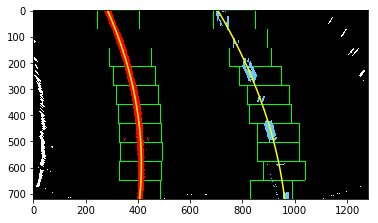

In [11]:
# visualize the result on example image
img = cv2.imread('./test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_bin, Minv = pipeline(img)
    
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window(img_bin)

h = img_bin.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]

rectangles = visualization_data[0]
histogram = visualization_data[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((img_bin, img_bin, img_bin))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, img_bin.shape[0]-1, img_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = img_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')


# Section-8

In [12]:
def polyfit_using_prev(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

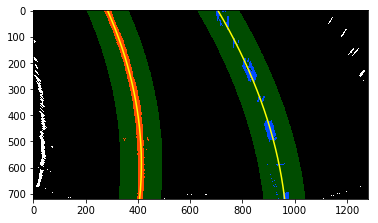

In [13]:
img2 = cv2.imread('./test_images/test2.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2_bin, Minv = pipeline(img2)   
margin = 80

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev(img2_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, img2_bin.shape[0]-1, img2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((img2_bin, img2_bin, img2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = img2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx2-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx2+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx2-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx2+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')

# Section-9

In [14]:
def curv_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.5/80 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

In [15]:
lane_l, lane_r, d_center = curv_and_center_dist(img_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature:', (lane_l + lane_r)/2, 'm')
print('Distance from lane center:', d_center, 'm')

Radius of curvature: 518.2530579878701 m
Distance from lane center: -0.23284730999161052 m


In [16]:
print(lane_l)
print(lane_r)

481.0851179385775
555.4209980371627


In [17]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (150,100, 100))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(0,0,255), thickness=35)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=25)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

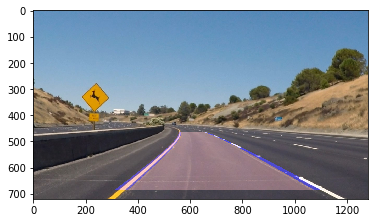

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

IMG = draw_lane(img, img_bin, left_fit, right_fit, Minv)
plt.imshow(IMG)

In [19]:
def print_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (180,170), font, 2.0, (255,155,55), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (180,220), font, 2.0, (255,155,55), 2, cv2.LINE_AA)
    return new_img

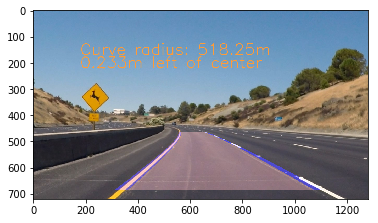

In [20]:
out2 = print_data(IMG, (lane_l+lane_r)/2, d_center)
plt.imshow(out2)

In [21]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
        
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares to the existing best_fit
                self.diffs = abs(fit-self.best_fit)
            # we compare the new fit quantitatively 
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # Replace old  fit with new ones
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                # best_fit is an average of the last 5 polynomial_fits
                self.best_fit = np.average(self.current_fit, axis=0)
        else:
            # Declare that no new suitable fit was found 
            self.detected = False
            if len(self.current_fit) > 0:
                # Remove oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
                self.best_fit = np.average(self.current_fit, axis=0)
                

# Section-10

In [22]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(550 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = curv_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = print_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    return img_out

In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

l_line = Line()
r_line = Line()
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4') #.subclip(5,20)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:10<00:00,  3.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 6min 11s
